In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [ ]:
wid = 100
oversample = 4

nwavels = 10
npoly=2

n_zernikes = 12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

# some other early calibrator

files = [
    'n8yj53vfq_cal.fits'

]


# lhs 1846
ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits", "n8ku01fgq_cal.fits"][:1]

"""ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    "n43ca5fjq_cal.fits",
    "n43ca5fkq_cal.fits",
    "n43ca5flq_cal.fits",
    "n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    "n43ca5ffq_cal.fits",
    "n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    "n43c03dnq_cal.fits",
    "n43c03doq_cal.fits",
    "n43c03dpq_cal.fits",
    "n43c03drq_cal.fits",
    #F108N
    "n43c03dsq_cal.fits",
    "n43c03duq_cal.fits",
    "n43c03dvq_cal.fits",
    "n43c03dwq_cal.fits",
]
"""

ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    'n4be02nqq_cal.fits',
    'n4be02ntq_cal.fits',
    #'n4be02nwq_cal.fits',
    #'n4be02o0q_cal.fits',
][:1]#[-2:-1]

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

Filename: ../data/MAST_2025-03-06T11_35_52.340Z/HST/n4be02nqq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     300   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.0
2.31197
Filename: ../data/MAST_2025-03-06T11_35_52.340Z/HST/n4be02ntq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     300   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          

In [5]:
data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()

print(files)


#exposures_single = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files][:10]

['na2a12jmq_cal.fits', 'na2a12jnq_cal.fits', 'na2a12joq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jqq_cal.fits', 'na2a12jxq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k0q_cal.fits', 'na2a12k1q_cal.fits', 'na2a12k2q_cal.fits', 'na2a12k9q_cal.fits', 'na2a12kbq_cal.fits', 'na2a12kcq_cal.fits', 'na2a12kdq_cal.fits', 'na2a12keq_cal.fits', 'na2a12klq_cal.fits', 'na2a12knq_cal.fits', 'na2a12koq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kqq_cal.fits', 'na2a12kxq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l0q_cal.fits', 'na2a12l1q_cal.fits', 'na2a12l2q_cal.fits', 'na2a12lgq_cal.fits', 'na2a12liq_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lkq_cal.fits', 'na2a12llq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12luq_cal.fits', 'na2a12lvq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12lxq_cal.fits', 'na2a12m4q_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m7q_cal.fits', 'na2a12m8q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mgq_cal.fits', 'na2a12miq_cal.fits', 'na2a12mjq_cal.fits', 'na2a12mkq_cal.fits', 'na2a12mlq_cal.fits', 'na2a12ms

In [6]:
for e in exposures_single:
    print(e.mjd*86400)
    print(e.target)
    print(e.filter)

4384826674.486272
HD201592
F145M
4384826805.485951
HD201592
F145M


In [7]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
          -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
           7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8., 8.])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [8]:
exp.fit.get_key(exp, "primary_distortion")

'global'

In [9]:
optics

NICMOSOptics(
  wf_npixels=1024,
  diameter=2.4,
  layers={
    'CompoundAperture':
    CompoundAperture(
      normalise=True,
      transformation=CoordTransform(
        translation=None,
        rotation=f32[],
        compression=None,
        shear=None
      ),
      apertures={
        'main_aperture':
        HSTMainAperture(
          normalise=True,
          transformation=CoordTransform(
            translation=None,
            rotation=f32[],
            compression=None,
            shear=None
          ),
          apertures={
            'mirror':
            CircularAperture(
              normalise=False,
              transformation=None,
              occulting=False,
              softness=2.0,
              radius=1.2
            ),
            'spider':
            Spider(
              normalise=False,
              transformation=None,
              occulting=True,
              softness=2.0,
              width=0.026399999999999996,
              angles=f32[

In [10]:
#plt.imshow(exposures_single[0].fit(model_single,exposures_single[0])**0.125)

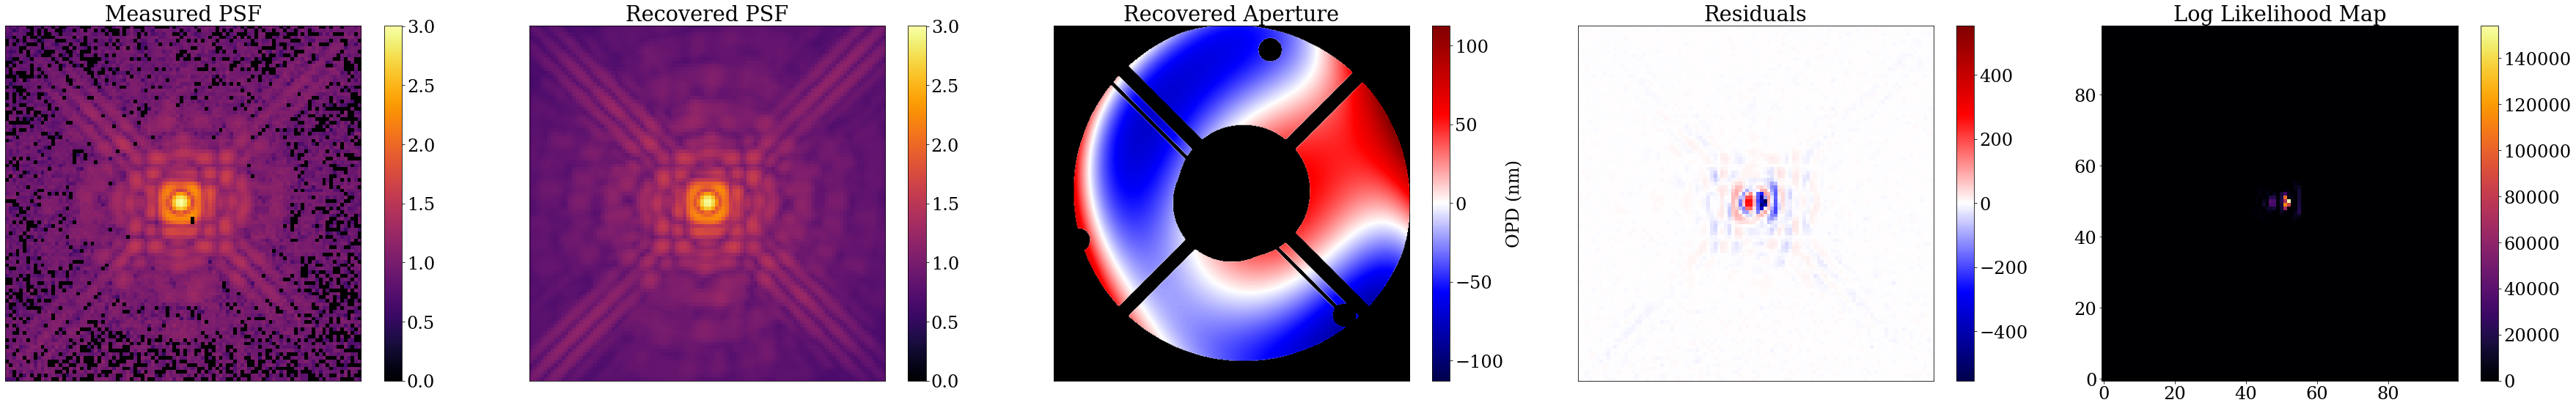

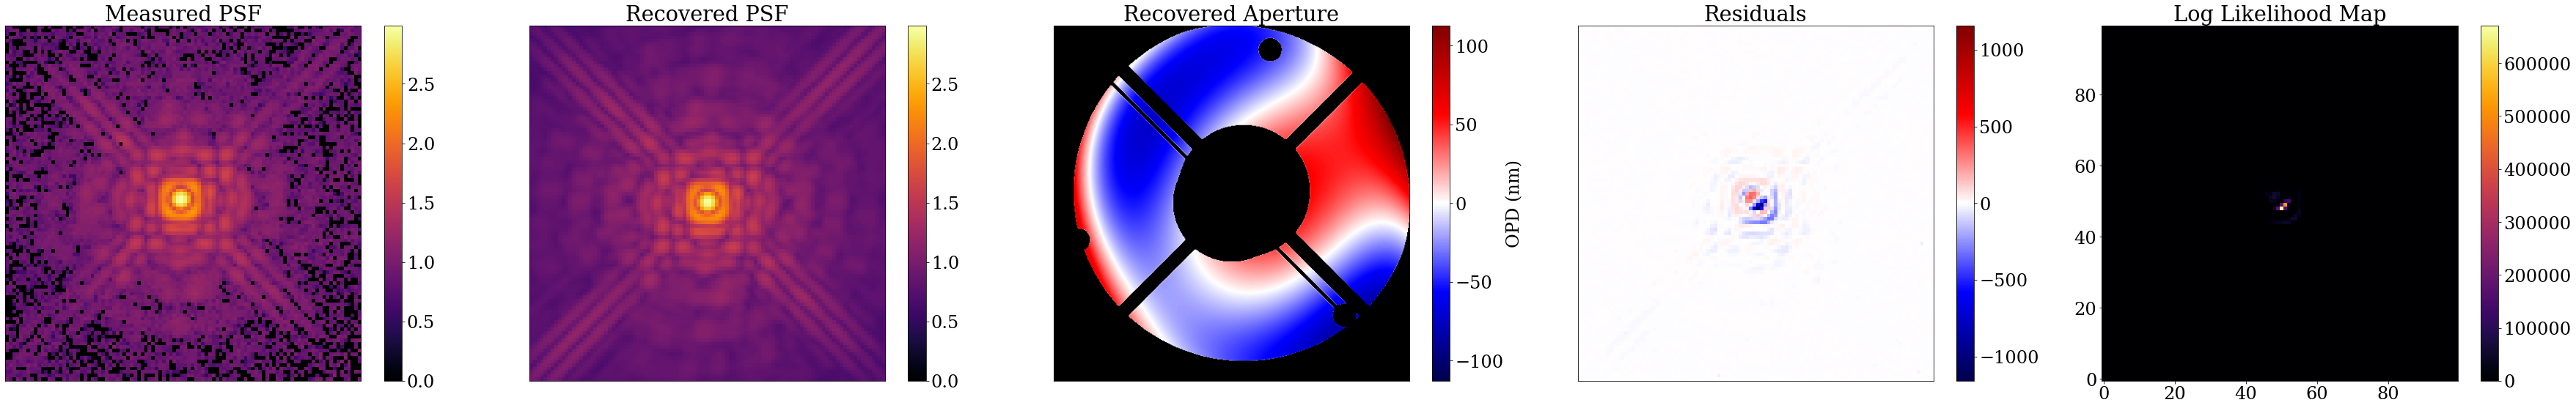

In [11]:
plot_comparison(model_single, params, exposures_single)

In [12]:
exposures_single[0].bad[35,60]

Array(False, dtype=bool)

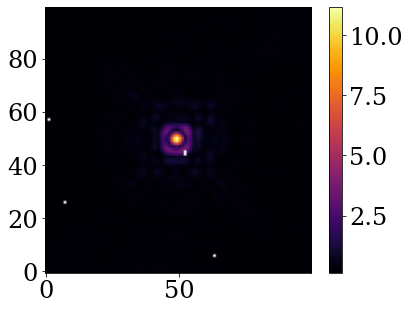

In [13]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

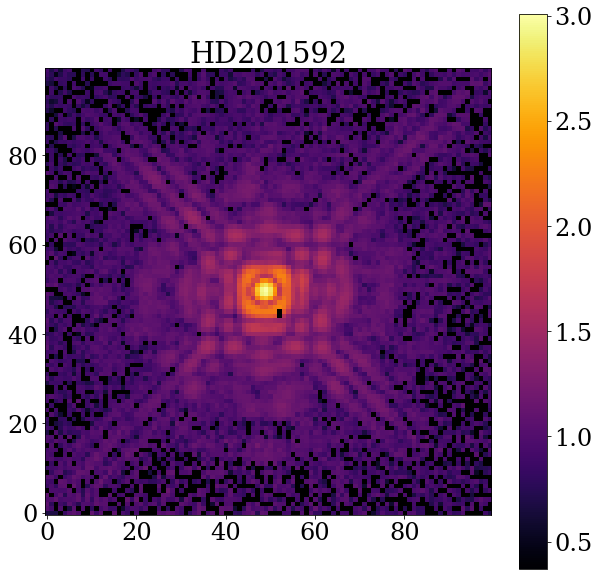

In [14]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [15]:
#stop

In [16]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [17]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*8, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*100, 30),
    "cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*3, 20),
    #"aberrations": opt(g*0.15,300),#, (80, 2)),#, (150, g*0.2)),
    #"aberrations": opta(2, 50),
    "aberrations": opta(2, 50),
    #"displacement": opt(g*30, 150),

    #"cold_mask_scale": opt(g*100, 250),
    #"cold_mask_shear": opt(g*100, 250),
    #"primary_scale": opt(g*100, 300),
    #"primary_shear": opt(g*100, 300),
}


groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [18]:
losses, models = optimise(params, model_single, exposures_single, things, 400)

Calculating Fishers


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'n4be02nqq': {'positions': Array([[9089223.  ,  186196.81],
       [ 186196.84, 5604091.  ]], dtype=float32), 'spectrum': Array([[55498024.  ,   674997.  ],
       [  674990.25,  5687606.5 ]], dtype=float32), 'cold_mask_shift': Array([[-190698.47 ,   17078.246],
       [  17078.252, -195729.3  ]], dtype=float32), 'cold_mask_rot': Array([[-372026.53]], dtype=float32), 'bias': Array([[167316.19]], dtype=float32), 'aberrations': Array([[ 2.65083160e+01, -2.72115154e+01, -2.74071732e+01,
        -8.43820000e+00,  2.51566525e+01, -2.87608929e+01,
        -3.15397024e+00,  3.85369339e+01, -3.99057269e+00,
        -8.26646614e+00, -1.77213311e+00, -9.37928963e+00],
       [-2.72110291e+01,  1.97877083e+01, -1.05839596e+01,
         2.20772572e+01,  1.75323391e+00,  1.15201540e+01,
        -4.78975916e+00, -1.62942410e+01, -3.92211318e+00,
         2.20622253e+01, -5.92382240e+00, -4.81153822e+00],
       [-2.74076977e+01, -1.05843525e+01,  4.68094215e+01,
         5.41350508e+00,  1.00464993

  0%|          | 0/400 [00:00<?, ?it/s]

In [19]:
losses[-1]

Array(80592.7, dtype=float32)

In [20]:
# 5.813

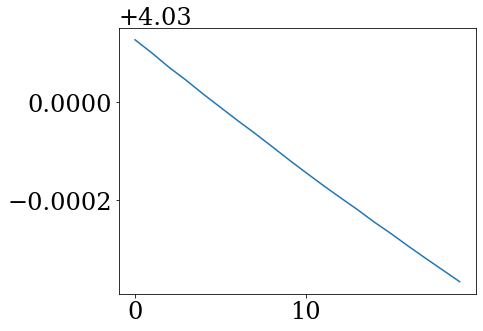

In [21]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

6


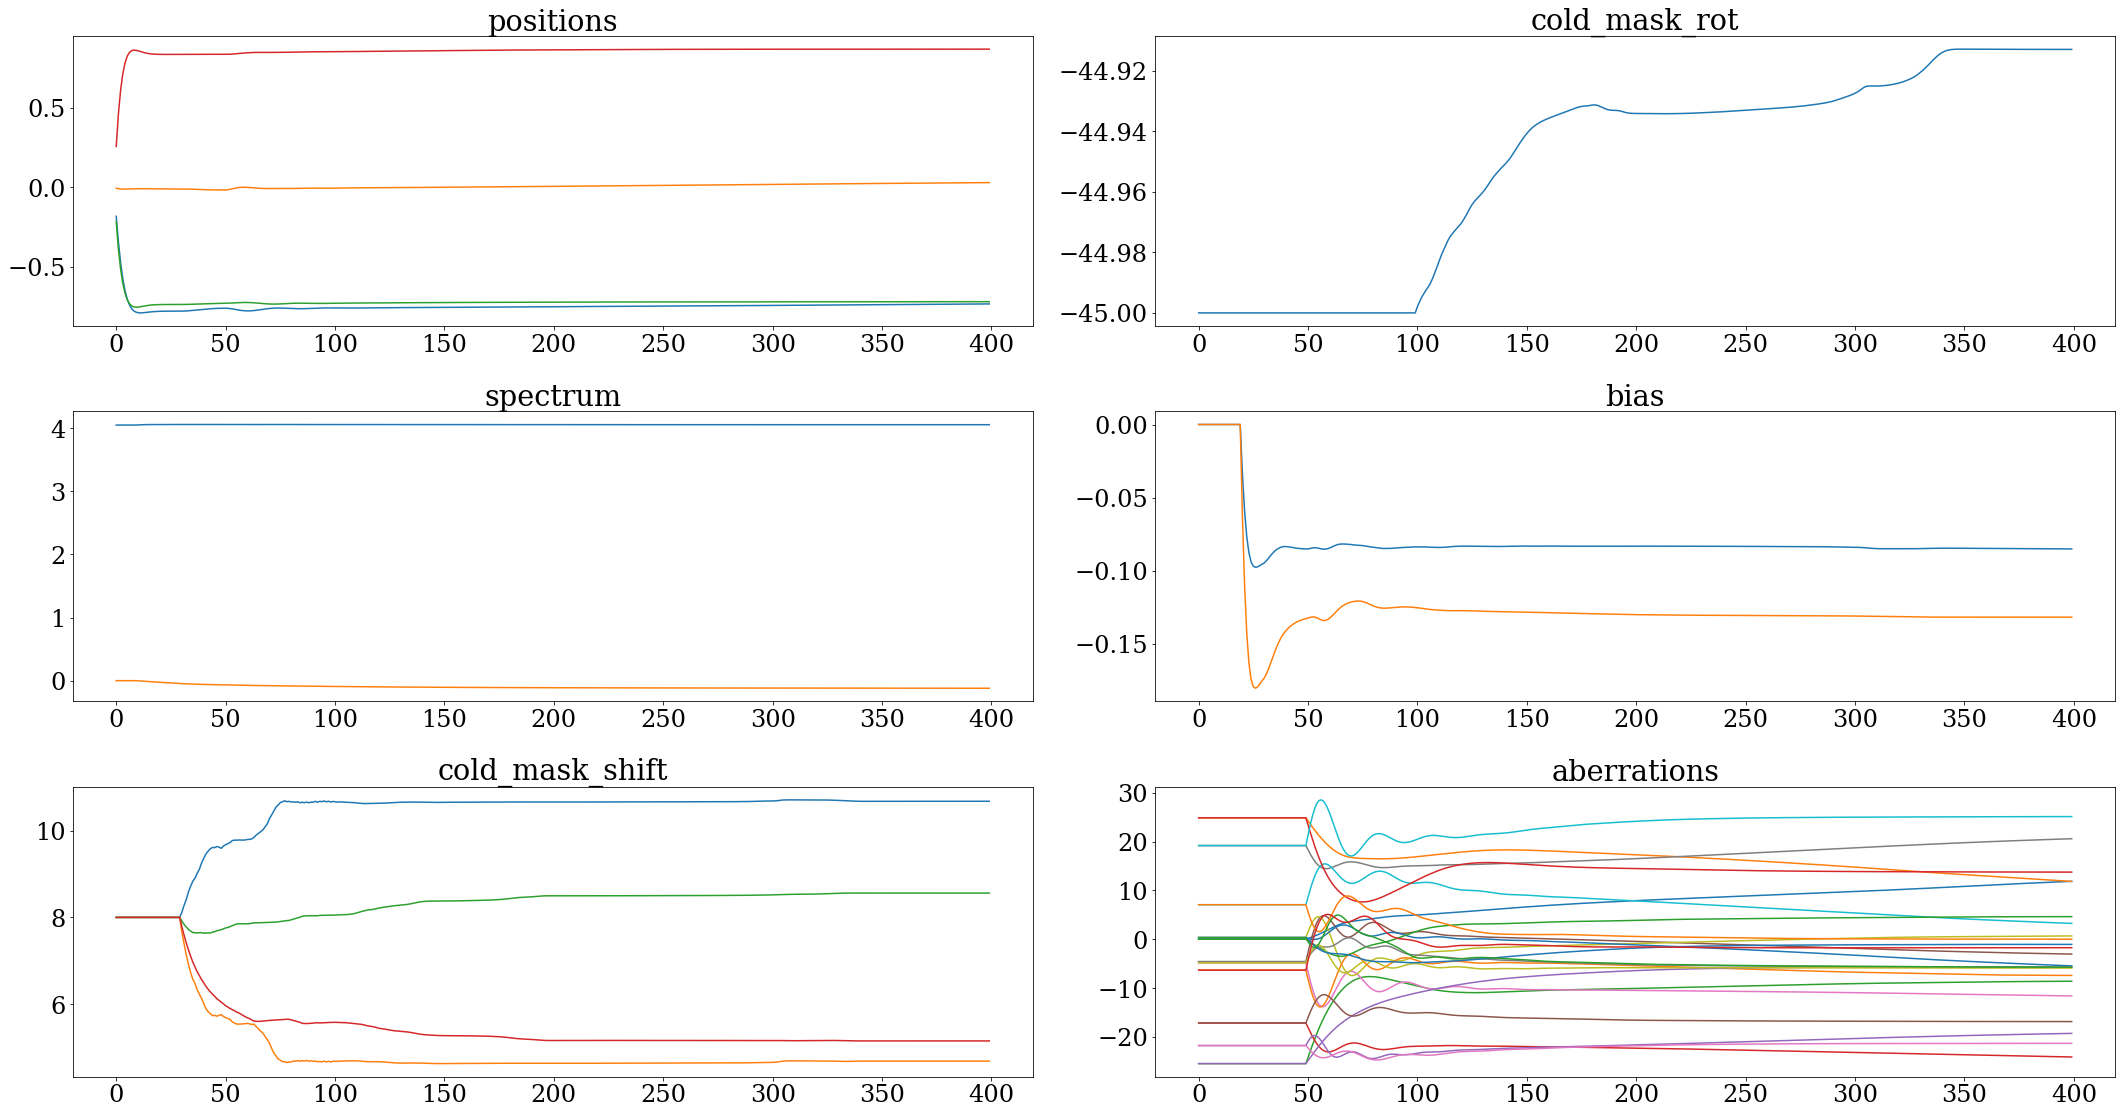

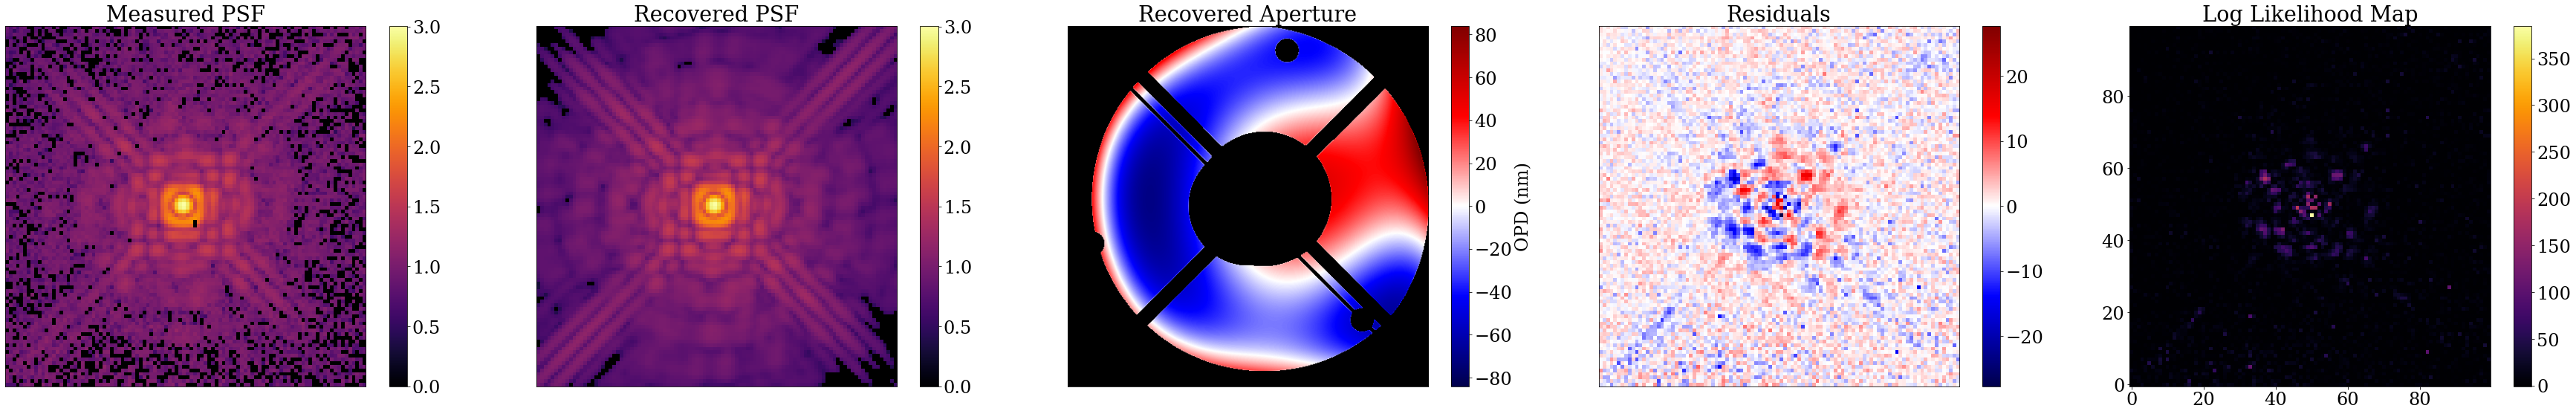

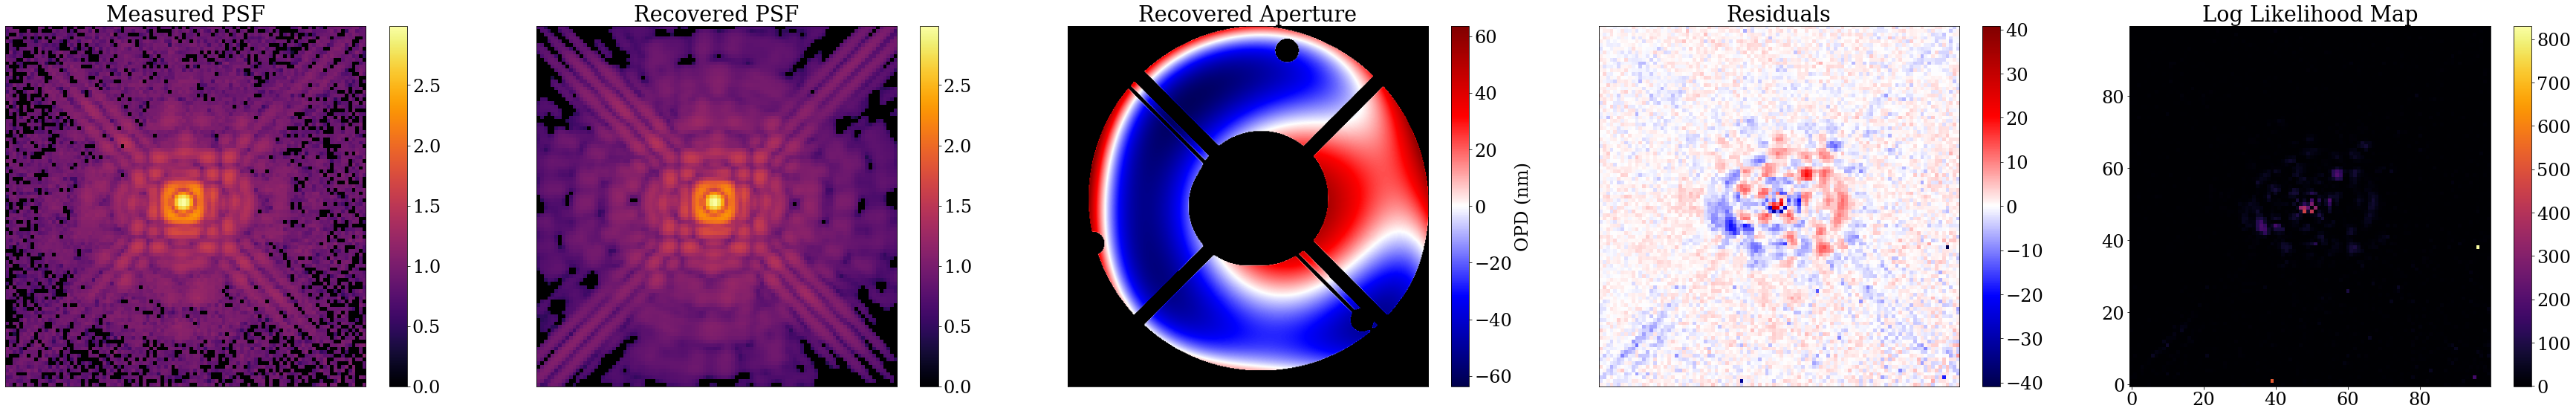

In [22]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [23]:
models[-1].params

{'aberrations': {'n4be02nqq': Array([ 11.873067 ,  11.851967 ,  -8.609938 , -24.128525 , -19.295832 ,
          -3.042146 , -11.621661 ,  20.598988 ,   0.6758958,   3.2451422,
          -5.456475 ,  -7.4145384], dtype=float32),
  'n4be02ntq': Array([ 4.6382518e+00,  1.3758700e+01, -5.6800528e+00, -1.6873539e+01,
         -2.1337084e+01, -5.6794224e+00, -5.9101067e+00,  2.5139662e+01,
         -1.0569296e+00,  1.1187848e-02, -5.7241163e+00, -1.7391860e+00],      dtype=float32)},
 'bias': {'n4be02nqq': Array(-0.08513639, dtype=float32),
  'n4be02ntq': Array(-0.13183178, dtype=float32)},
 'cold_mask_rot': {'global': Array(-44.91293, dtype=float32)},
 'cold_mask_scale': {'F145M': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F145M': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n4be02nqq': Array([10.678111,  4.685791], dtype=float32),
  'n4be02ntq': Array([8.560877 , 5.1518073], dtype=float32)},
 'jitter': {'n4be02nqq': 0.6511627906976745, 'n4be02ntq': 0.6511627906976745}

In [24]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, ["cold_mask_shift"], recalculate=True, save=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
fsh

{'n4be02nqq': {'cold_mask_shift': Array([[5286.316   ,   48.043873],
         [  48.043724, 3817.532   ]], dtype=float32)},
 'n4be02ntq': {'cold_mask_shift': Array([[6066.4634, 1573.0416],
         [1573.042 , 5623.4175]], dtype=float32)}}

In [26]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F170M", nwavels=nwavels)

#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("spectrum.LHS1846_F170M")).weights))#), yerr = spectrum_err)


KeyError: 'LHS1846_F170M'

<Figure size 720x720 with 0 Axes>

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(68, dtype=int32), Array(67, dtype=int32))

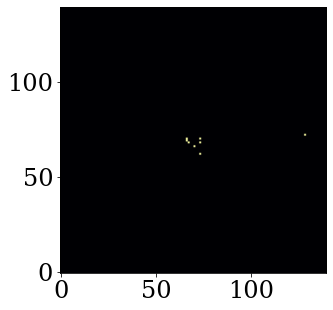

In [ ]:
plt.imshow(extra_bad)

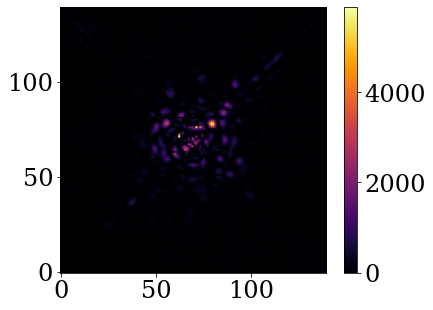

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)